In [1]:
from google.colab import drive
drive.flush_and_unmount()
!rm -rf /content/drive/*
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Function to load all images from a folder
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)

            # Convert to grayscale if needed (optional)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Ensure the image has the right shape (H, W, C)
            if len(img.shape) == 3:  # Color image
                images.append(img)
            elif len(img.shape) == 2:  # Grayscale image
                images.append(np.expand_dims(img, axis=-1))  # Add channel dimension
            else:
                print(f"Skipping {filename}: Unsupported image shape {img.shape}")

    print(f"Loaded {len(images)} images from {folder}")
    return np.array(images)

# Paths to the benign and malignant directories
benign_dir = "/content/drive/MyDrive/Kaggle_data1/benign"
malignant_dir = "/content/drive/MyDrive/Kaggle_data1/malignant"

# Load images from benign and malignant folders
benign_images = load_images_from_folder(benign_dir)
malignant_images = load_images_from_folder(malignant_dir)

# Combine the images
images = np.concatenate((benign_images, malignant_images), axis=0)

# Normalize images (0-1)
images = images.astype(np.float32) / 255.0  # Ensure correct dtype for normalization

# Shuffle images
np.random.shuffle(images)

print(f"Total images loaded: {images.shape[0]}")


Loaded 1800 images from /content/drive/MyDrive/Kaggle_data1/benign
Loaded 1497 images from /content/drive/MyDrive/Kaggle_data1/malignant
Total images loaded: 3297


In [3]:
benign_images = benign_images.astype(np.float32) / 255.0
malignant_images = malignant_images.astype(np.float32) / 255.0

In [ ]:
# Function to generate distinct synthetic masks for benign and malignant images
def generate_synthetic_masks(benign_images, malignant_images, threshold=128):
    masks = []

    # Generate benign masks (diffused or low-intensity masks)
    for image in benign_images:
        image_uint8 = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_image, threshold , 255, cv2.THRESH_BINARY)  # Lower threshold for benign
        mask = cv2.GaussianBlur(mask, (15, 15), 0)  # Diffuse edges for benign images
        mask = cv2.resize(mask, (128, 128))
        masks.append(mask / 255.0)

    # Generate malignant masks (higher intensity, more focused regions)
    for image in malignant_images:
        image_uint8 = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_image, threshold , 255, cv2.THRESH_BINARY)  # Higher threshold for malignant
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))  # Enhance edges for malignant
        mask = cv2.resize(mask, (128, 128))
        masks.append(mask / 255.0)

    return np.array(masks).reshape(-1, 128, 128, 1)

# Generate synthetic masks for the benign and malignant images
lesion_masks = generate_synthetic_masks(benign_images, malignant_images)

# Combine benign and malignant images for final dataset
images = np.concatenate((benign_images, malignant_images), axis=0)

# Shuffle images and masks together
shuffled_indices = np.random.permutation(len(images))
images = images[shuffled_indices]
lesion_masks = lesion_masks[shuffled_indices]

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, lesion_masks, test_size=0.2, random_state=42)

# Print shapes of training and validation datasets
print(f"Training images shape: {X_train.shape}, Training masks shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}, Validation masks shape: {y_val.shape}")

Training images shape: (2637, 128, 128, 3), Training masks shape: (2637, 128, 128, 1)
Validation images shape: (660, 128, 128, 3), Validation masks shape: (660, 128, 128, 1)


In [5]:
import numpy as np
from sklearn.metrics import adjusted_rand_score, cohen_kappa_score

def jaccard_coef(y_true, y_pred, smooth=1e-10, threshold=0.5):
    """
    Calculate the Jaccard coefficient (Intersection over Union).

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - smooth: Smoothing factor to avoid division by zero.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Jaccard coefficient value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply threshold to convert predictions to binary
    y_pred = (y_pred > threshold).astype(int)

    # Flatten the arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Calculate intersection and union
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection

    # Calculate the Jaccard coefficient (IoU)
    jac = (intersection + smooth) / (union + smooth)
    return jac


def dice_coef(y_true, y_pred, smooth=1e-10, threshold=0.5):
    """
    Calculate the Dice coefficient.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - smooth: Smoothing factor to avoid division by zero.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Dice coefficient value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply threshold to convert predictions to binary
    y_pred = (y_pred > threshold).astype(int)

    # Flatten the arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Calculate intersection and sums
    intersection = np.sum(y_true_f * y_pred_f)
    sum_y_true = np.sum(y_true_f)
    sum_y_pred = np.sum(y_pred_f)

    # Calculate the Dice coefficient
    dice = (2. * intersection + smooth) / (sum_y_true + sum_y_pred + smooth)
    return dice


def rand_index(y_true, y_pred):
    """
    Calculate the Adjusted Rand Index.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.

    Returns:
    - Adjusted Rand Index value.
    """
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    y_pred = (y_pred > 0.5).astype(int)

    # Calculate Adjusted Rand Index using scikit-learn
    ari = adjusted_rand_score(y_true, y_pred)
    return ari

import numpy as np
from sklearn.metrics import cohen_kappa_score

def cohen_kappa(y_true, y_pred, threshold=0.5):
    """
    Calculate Cohen's Kappa score.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Cohen's Kappa score value.
    """
    # Convert both y_true and y_pred to binary
    y_true = (np.array(y_true).flatten() > threshold).astype(int)
    y_pred = (np.array(y_pred).flatten() > threshold).astype(int)

    # Calculate Cohen's Kappa using scikit-learn
    kappa = cohen_kappa_score(y_true, y_pred)
    return kappa



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# Define the model for segmentation
def build_segnet(hyperparams):
    inputs = Input(shape=(128, 128, 3))

    # Encoder
    x = Conv2D(hyperparams['conv_filters_1'], kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(hyperparams['conv_filters_1'], kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    p1 = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(hyperparams['conv_filters_2'], kernel_size=(3, 3), activation='relu', padding='same')(p1)
    x = BatchNormalization()(x)
    x = Conv2D(hyperparams['conv_filters_2'], kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    p2 = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(hyperparams['conv_filters_3'], kernel_size=(3, 3), activation='relu', padding='same')(p2)
    x = BatchNormalization()(x)
    x = Conv2D(hyperparams['conv_filters_3'], kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    p3 = MaxPooling2D(pool_size=(2, 2))(x)

    # Bottleneck
    x = Conv2D(hyperparams['conv_filters_3'], kernel_size=(3, 3), activation='relu', padding='same')(p3)
    x = BatchNormalization()(x)

    # Decoder
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(hyperparams['conv_filters_3'], kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(hyperparams['conv_filters_2'], kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(hyperparams['conv_filters_1'], kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Output layer
    outputs = Conv2D(1, kernel_size=(1, 1), activation='sigmoid', padding='same')(x)

    # Create the model
    model = Model(inputs, outputs)

    # Compile the model using binary crossentropy for segmentation tasks
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparams['learning_rate']),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
import random
import numpy as np

# Define the range of hyperparameters to optimize
param_space = {
    'conv_filters_1': [32, 64],
    'conv_filters_2': [64, 128],
    'conv_filters_3': [32, 128],
    'learning_rate': [1e-4, 1e-3],
    'dropout_rate': [0.1, 0.3]  # Add dropout rates to the parameter space
}

# Function to generate a random individual (hyperparameter set)
def random_individual(param_space):
    individual = {param: random.choice(values) for param, values in param_space.items()}
    return individual

# Fitness function: Train and evaluate the model with the given hyperparameters
def fitness(individual):
    # Create the model with the individual's hyperparameters
    model = build_segnet(individual)

    # Compile the model with a learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=individual['learning_rate']),
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model on training data and evaluate on validation data (use small epochs for speed)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32, verbose=0)

    # Return validation accuracy as the fitness score
    val_acc = np.max(history.history['val_accuracy'])
    return val_acc

# Genetic algorithm functions: selection, crossover, mutation
def selection(population, fitness_scores):
    # Select individuals with the highest fitness scores (top 50%)
    selected_idx = np.argsort(fitness_scores)[-len(population)//2:]
    selected = [population[i] for i in selected_idx]
    return selected

def crossover(parent1, parent2):
    # Create a child by randomly combining hyperparameters from both parents
    child = {key: random.choice([parent1[key], parent2[key]]) for key in parent1.keys()}
    return child

def mutate(individual, mutation_rate=0.1):
    # Randomly mutate some hyperparameters with a given probability
    for param in individual:
        if random.random() < mutation_rate:
            individual[param] = random.choice(param_space[param])
    return individual

# Main genetic algorithm loop
def genetic_algorithm(param_space, population_size=10, generations=5, mutation_rate=0.1):
    # Initialize population with random individuals
    population = [random_individual(param_space) for _ in range(population_size)]

    for generation in range(generations):
        # Evaluate fitness for each individual
        fitness_scores = [fitness(ind) for ind in population]

        # Selection: keep the top 50% of individuals
        selected_population = selection(population, fitness_scores)

        # Generate new population by crossover and mutation
        new_population = []
        while len(new_population) < population_size:
            parent1, parent2 = random.sample(selected_population, 2)  # Select two parents
            child = crossover(parent1, parent2)  # Perform crossover
            child = mutate(child, mutation_rate)  # Perform mutation
            new_population.append(child)

        # Update population
        population = new_population

        # Print the best fitness score of this generation
        print(f"Generation {generation + 1}, Best Fitness: {max(fitness_scores)}")

    # Return the best individual
    final_fitness_scores = [fitness(ind) for ind in population]
    best_individual = population[np.argmax(final_fitness_scores)]
    return best_individual

# Run the genetic algorithm
best_hyperparams = genetic_algorithm(param_space, population_size=4, generations=4, mutation_rate=0.1)
print("Best hyperparameters found:", best_hyperparams)

Generation 1, Best Fitness: 0.8389592170715332
Generation 2, Best Fitness: 0.8381233811378479
Generation 3, Best Fitness: 0.8367083668708801
Generation 4, Best Fitness: 0.8340175747871399
Best hyperparameters found: {'conv_filters_1': 64, 'conv_filters_2': 128, 'conv_filters_3': 128, 'learning_rate': 0.001, 'dropout_rate': 0.3}


In [ ]:
# Retrain the model with the best hyperparameters found by the genetic algorithm
best_model = build_segnet(best_hyperparams)

# Compile the model with the best learning rate found by GA
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparams['learning_rate']),
                   loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the full training set and early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                         epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 247ms/step - accuracy: 0.7597 - loss: 0.4311 - val_accuracy: 0.6781 - val_loss: 0.7337
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.8252 - loss: 0.2765 - val_accuracy: 0.7089 - val_loss: 0.6432
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.8276 - loss: 0.2527 - val_accuracy: 0.7650 - val_loss: 0.4713
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.8310 - loss: 0.2412 - val_accuracy: 0.7588 - val_loss: 0.3817
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.8285 - loss: 0.2415 - val_accuracy: 0.8290 - val_loss: 0.2755
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.8348 - loss: 0.2317 - val_accuracy: 0.8348 - val_loss: 0.2233
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.8321 - loss: 0.2353 - val_accuracy: 0.8256 - val_loss: 0.2208
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.8291 - loss: 0.2292 - val_accu

In [ ]:
# Make predictions on the validation set
predictions = best_model.predict(X_val)

# Evaluate the predictions using various metrics
jaccard_score = jaccard_coef(y_val, predictions)
dice_score = dice_coef(y_val, predictions)
ari_score = rand_index(y_val, predictions)
kappa_score = cohen_kappa(y_val, predictions)

print(f"Jaccard Index: {jaccard_score:.4f}")
print(f"Dice Coefficient: {dice_score:.4f}")
print(f"Adjusted Rand Index: {ari_score:.4f}")
print(f"Cohen's Kappa: {kappa_score:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


Jaccard Index: 0.9048
Dice Coefficient: 0.9500
Adjusted Rand Index: 0.6389
Cohen's Kappa: 0.8216


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step


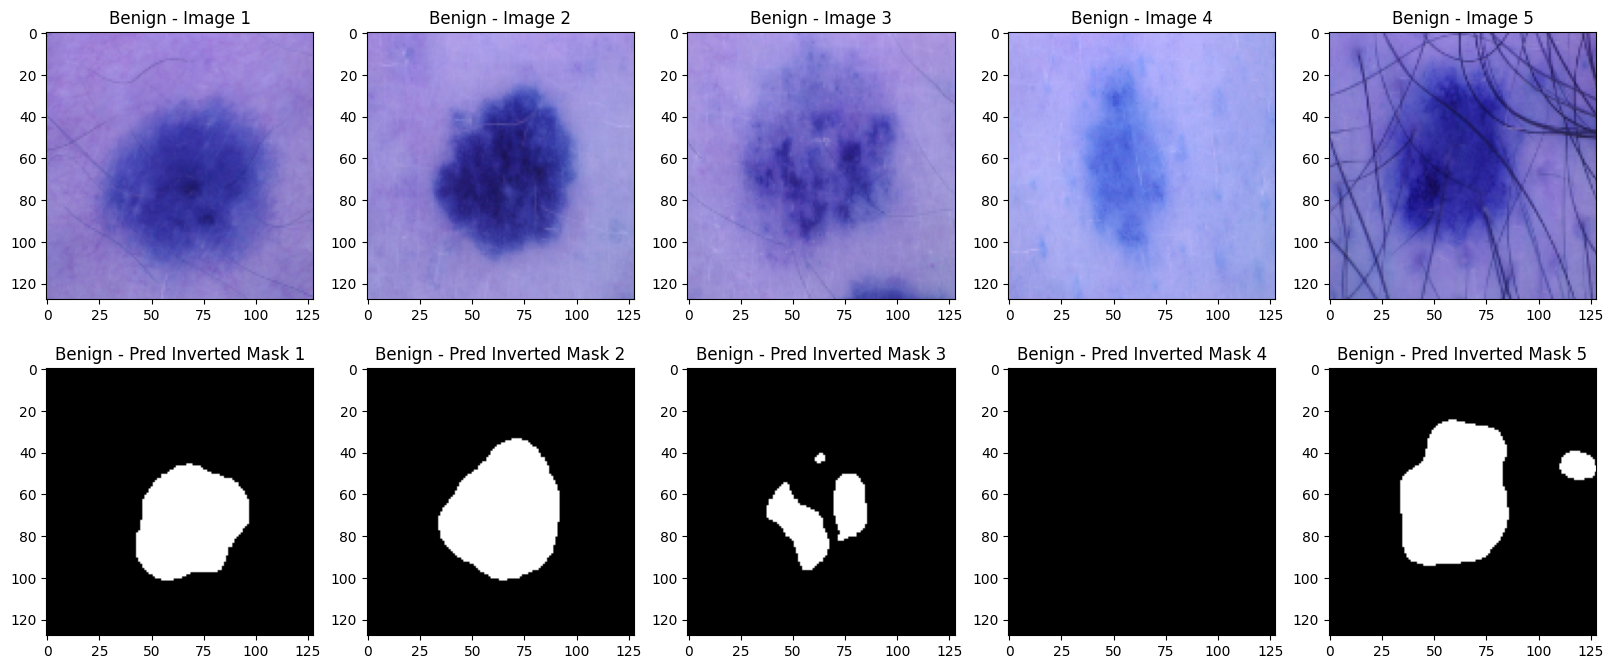

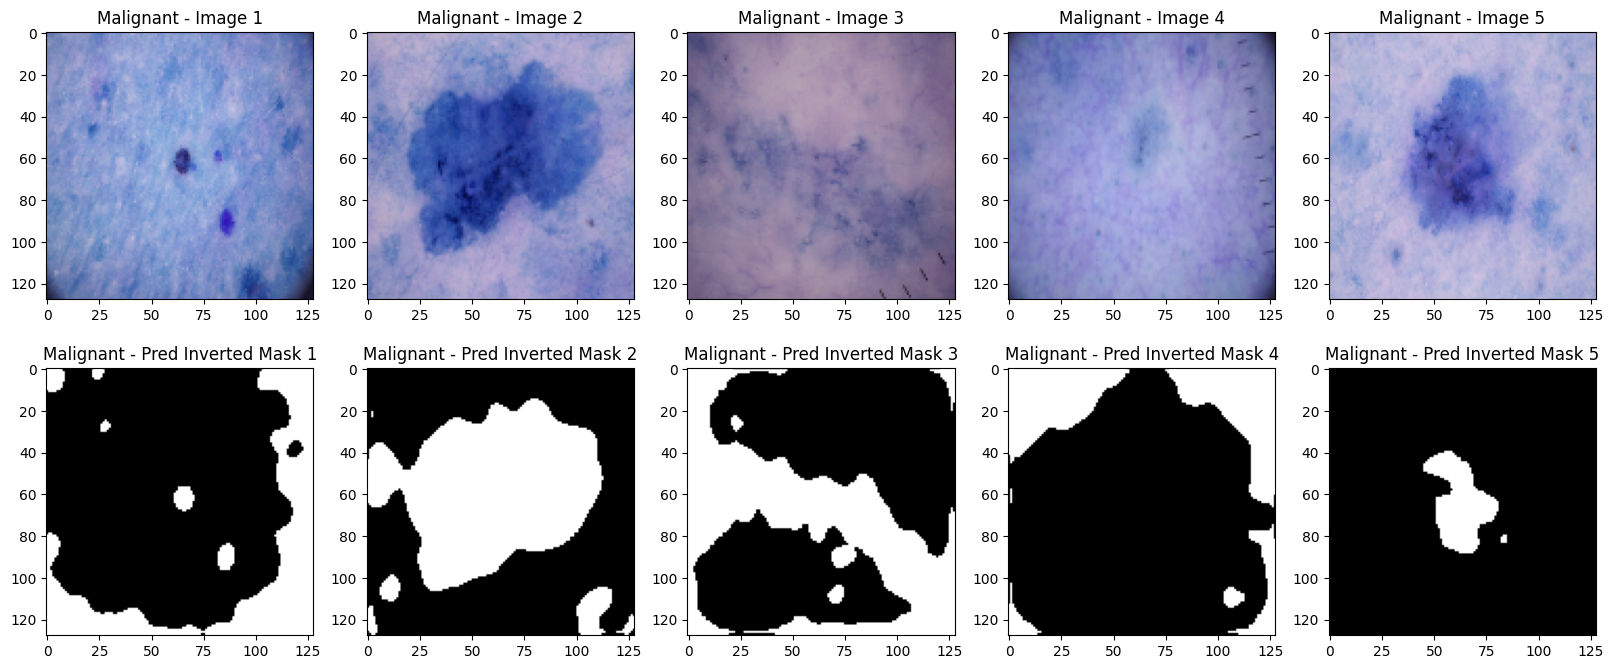

In [ ]:
predictions_benign = best_model.predict(benign_images)
predictions_malignant = best_model.predict(malignant_images)

# Convert predictions to binary and invert them
predictions_binary_benign = (predictions_benign > 0.5).astype(np.uint8)
predictions_inverted_benign = 1 - predictions_binary_benign

predictions_binary_malignant = (predictions_malignant > 0.5).astype(np.uint8)
predictions_inverted_malignant = 1 - predictions_binary_malignant

import matplotlib.pyplot as plt
# Function to display images and predicted inverted masks (no true masks)
def display_images(images, pred_masks, title):
    plt.figure(figsize=(20, 8))
    for i in range(5):
        # Display original images
        plt.subplot(2, 5, i + 1)
        plt.title(f"{title} - Image {i+1}")
        plt.imshow(images[i])

        # Display predicted inverted masks
        plt.subplot(2, 5, i + 6)
        plt.title(f"{title} - Pred Inverted Mask {i+1}")
        plt.imshow(pred_masks[i].squeeze(), cmap='gray')

    plt.show()

# Display 5 benign images with predicted inverted masks
display_images(benign_images[:5], predictions_inverted_benign[:5], title="Benign")

# Display 5 malignant images with predicted inverted masks
display_images(malignant_images[:5], predictions_inverted_malignant[:5], title="Malignant")

In [ ]:
best_model.save('/content/drive/MyDrive/best_model_segnet_GA_updated_hehehe.h5')  # Save the model to Google Drive or any desired directory

print("Model saved successfully!")

Model saved successfully!


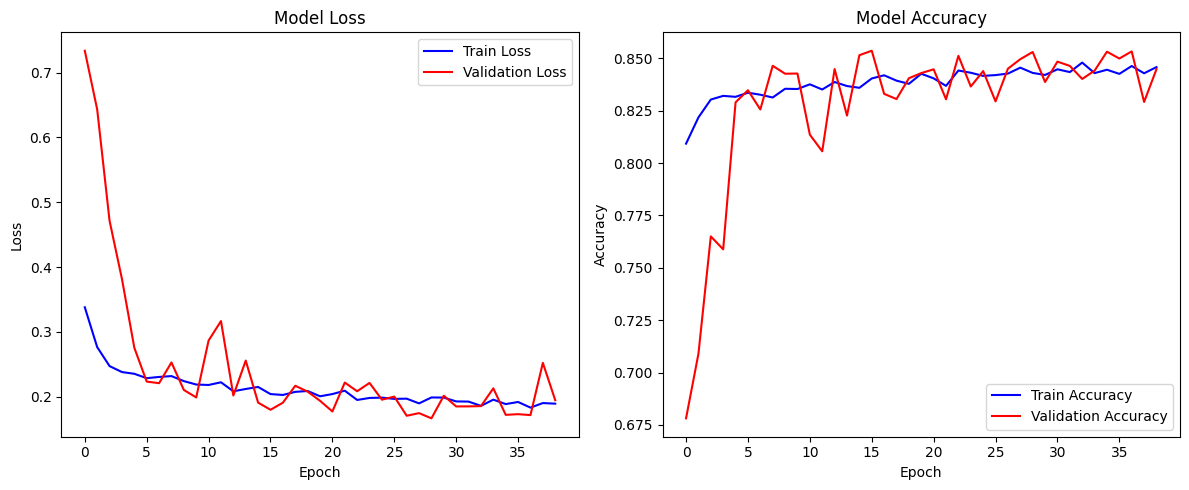

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='b')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='b')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='r')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Show the plots
plt.tight_layout()
plt.show()


In [6]:
pip install pyswarm


  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=78e0b3c16b926936fc1a40fabc64486e9ddb3c2d5a2374f31a14a2ea0687811d
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [8]:
import numpy as np
from pyswarm import pso
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
# Define the model for segmentation with hyperparameters as inputs
def build_segnet_pso(hyperparams):
    inputs = Input(shape=(128, 128, 3))

    # First convolutional block
    x = Conv2D(int(hyperparams[0]), kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second convolutional block
    x = Conv2D(int(hyperparams[1]), kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Upsampling
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(int(hyperparams[2]), kernel_size=(3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(1, kernel_size=(1, 1), activation='sigmoid', padding='same')(x)  # Output layer

    # Create model
    model = Model(inputs, x)

    # Compile the model with Adam optimizer and binary crossentropy loss
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hyperparams[3]),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Function to evaluate the fitness (validation loss)
def fitness_function(hyperparams):
    model = build_segnet_pso(hyperparams)

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model on the training data
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stopping], verbose=0)

    # Get the validation loss (last epoch's value)
    val_loss = history.history['val_loss'][-1]

    return val_loss

# Define the hyperparameter ranges: [conv_filters_1, conv_filters_2, conv_filters_3, learning_rate]
lower_bounds = [32, 32, 32, 1e-5]  # Minimum values for the hyperparameters
upper_bounds = [128, 64, 128, 1e-2]  # Maximum values for the hyperparameters

# Run PSO
best_hyperparams, best_loss = pso(fitness_function, lower_bounds, upper_bounds, swarmsize=4, maxiter=3)

print("Best hyperparameters found by PSO:", best_hyperparams)
print("Best validation loss:", best_loss)


Stopping search: maximum iterations reached --> 3
Best hyperparameters found by PSO: [8.49026967e+01 4.05803646e+01 1.00535135e+02 1.35643574e-03]
Best validation loss: 0.20353153347969055


In [9]:
# Unpack the best hyperparameters found by PSO
conv_filters_1, conv_filters_2, conv_filters_3, learning_rate = best_hyperparams

# Build the model with the optimized hyperparameters
best_model = build_segnet_pso([conv_filters_1, conv_filters_2, conv_filters_3, learning_rate])

# Train the model on the training set with the best hyperparameters
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                         epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1)


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6835 - loss: 0.5162 - val_accuracy: 0.7688 - val_loss: 0.4362
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7725 - loss: 0.3618 - val_accuracy: 0.8289 - val_loss: 0.2713
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8037 - loss: 0.2917 - val_accuracy: 0.8176 - val_loss: 0.2574
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8167 - loss: 0.2632 - val_accuracy: 0.8383 - val_loss: 0.2603
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8165 - loss: 0.2649 - val_accuracy: 0.8273 - val_loss: 0.2456
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8162 - loss: 0.2531 - val_accuracy: 0.8452 - val_loss: 0.2239
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8142 - loss: 0.2708 - val_accuracy: 0.8450 - val_loss: 0.2299
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8257 - loss: 0.2446 - val_accuracy: 0.8088 - v

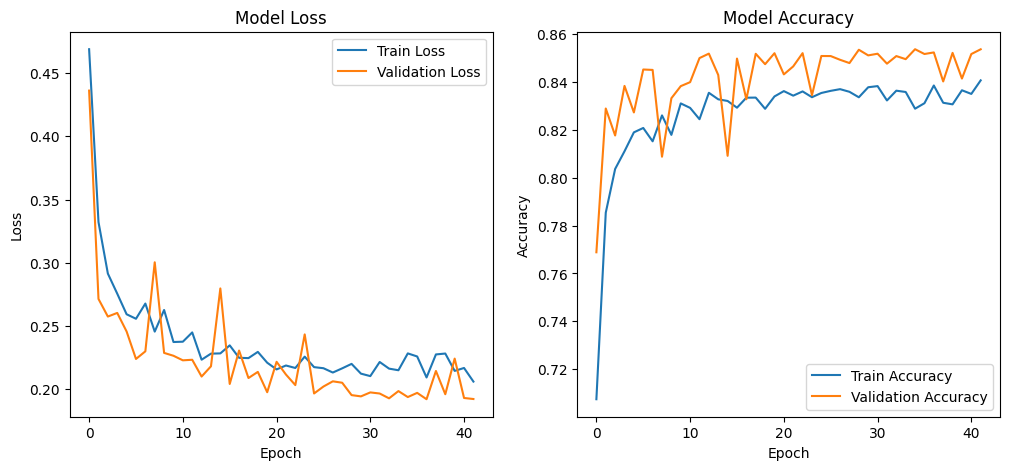

In [10]:

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [11]:
# Predict on validation set
y_pred_val = best_model.predict(X_val)
# Calculate Jaccard coefficient (IoU)
jaccard_score = jaccard_coef(y_val, y_pred_val)
print(f"Jaccard Coefficient (IoU): {jaccard_score}")
dice_Score=dice_coef(y_val,y_pred_val)
print(f"Dice Coefficient : {dice_Score}")
cohens=cohen_kappa(y_val,y_pred_val)
print(f"Cohen's Kappa  : {cohens}")
rand=rand_index(y_val,y_pred_val)
print(f"Rand index  : {rand}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Jaccard Coefficient (IoU): 0.8922227824851032
Dice Coefficient : 0.9430420040850843
Cohen's Kappa  : 0.7957176724064878


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


Rand index  : 0.6245449351374919


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


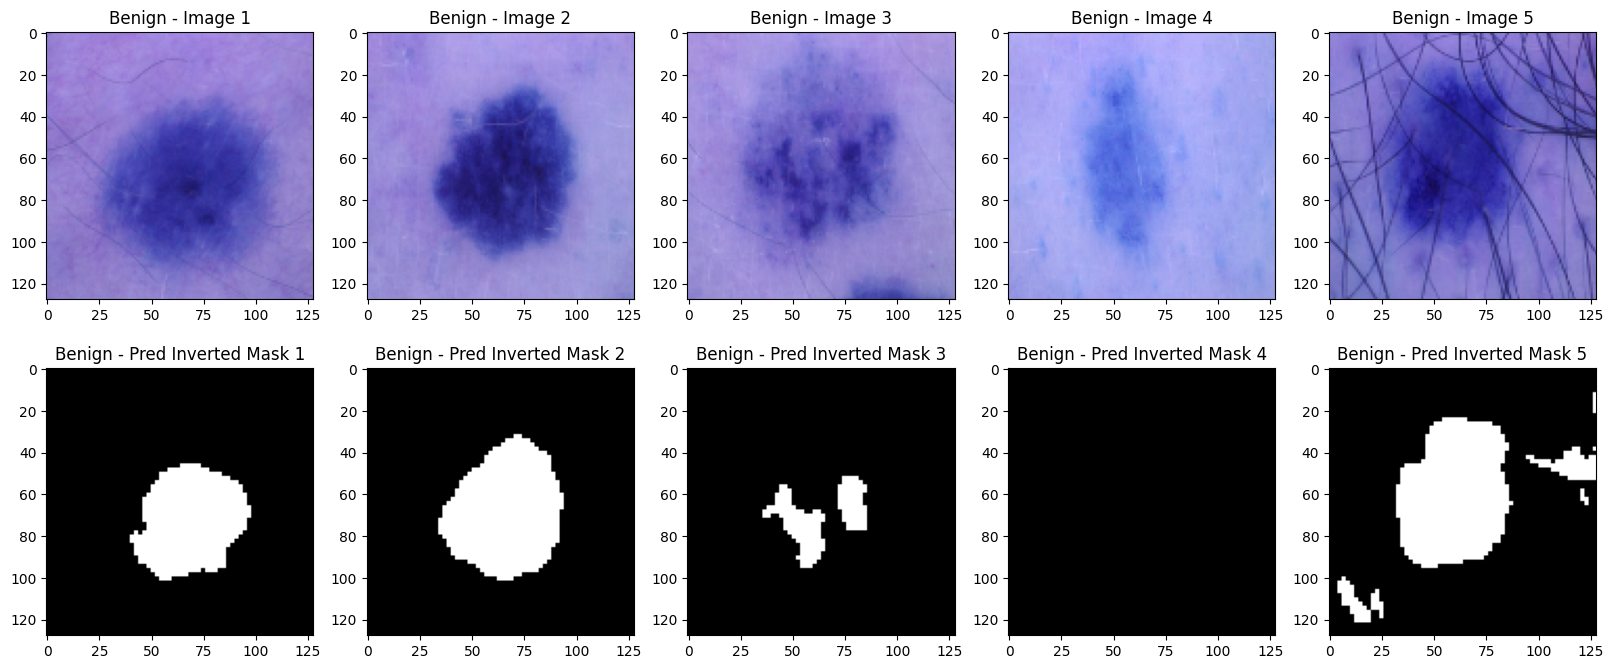

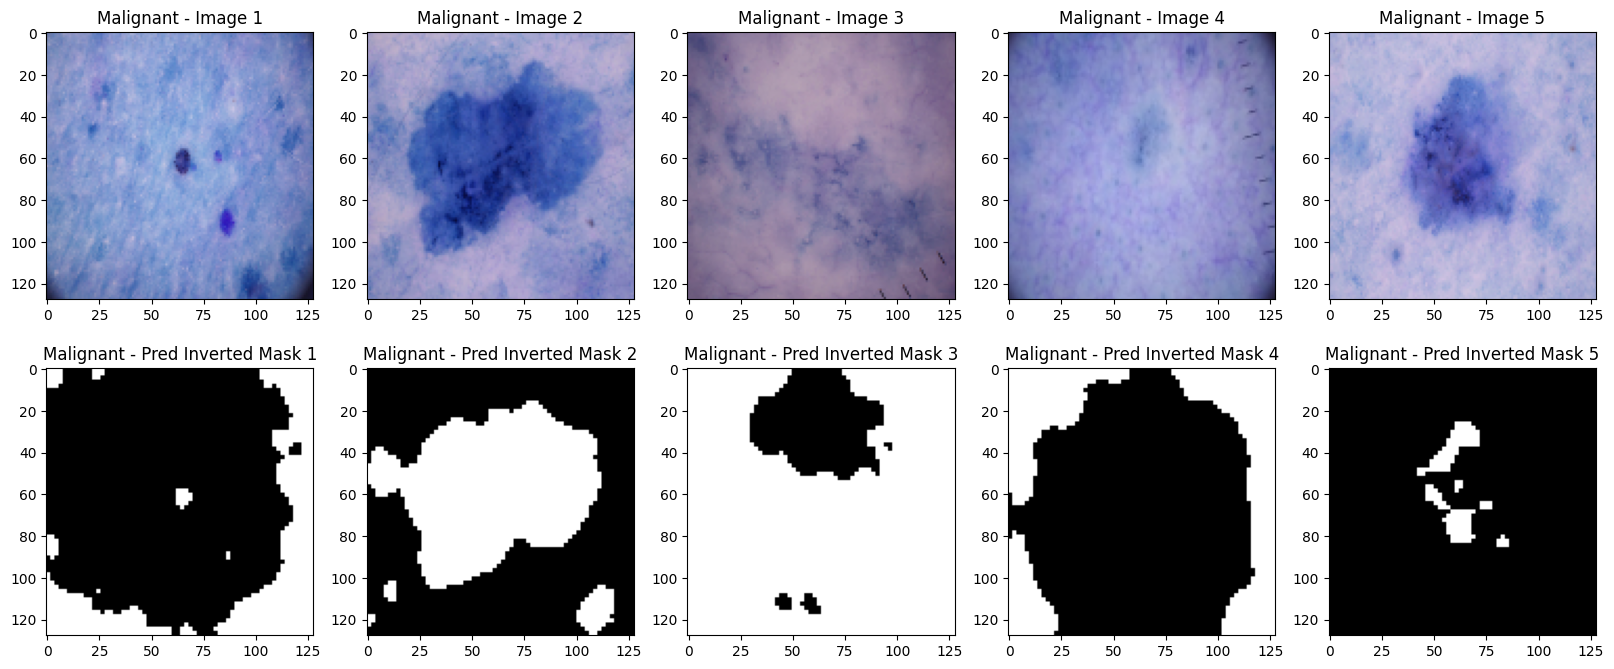

In [12]:
predictions_benign = best_model.predict(benign_images)
predictions_malignant = best_model.predict(malignant_images)

# Convert predictions to binary and invert them
predictions_binary_benign = (predictions_benign > 0.5).astype(np.uint8)
predictions_inverted_benign = 1 - predictions_binary_benign

predictions_binary_malignant = (predictions_malignant > 0.5).astype(np.uint8)
predictions_inverted_malignant = 1 - predictions_binary_malignant

import matplotlib.pyplot as plt
# Function to display images and predicted inverted masks (no true masks)
def display_images(images, pred_masks, title):
    plt.figure(figsize=(20, 8))
    for i in range(5):
        # Display original images
        plt.subplot(2, 5, i + 1)
        plt.title(f"{title} - Image {i+1}")
        plt.imshow(images[i])

        # Display predicted inverted masks
        plt.subplot(2, 5, i + 6)
        plt.title(f"{title} - Pred Inverted Mask {i+1}")
        plt.imshow(pred_masks[i].squeeze(), cmap='gray')

    plt.show()

# Display 5 benign images with predicted inverted masks
display_images(benign_images[:5], predictions_inverted_benign[:5], title="Benign")

# Display 5 malignant images with predicted inverted masks
display_images(malignant_images[:5], predictions_inverted_malignant[:5], title="Malignant")

In [13]:
best_model.save('/content/drive/MyDrive/best_model_segnet_PSO_hehehe.h5')  # Save the model to Google Drive or any desired directory

print("Model saved successfully!")

Model saved successfully!
